# Laboratório 3: Classificando textos com a base de dados IMDB

Bem vindo ao laboratório 3 do Mini curso de TensorFlow, neste tutorial vamos aprender a classificar avaliacoes de filmes utilizando o TensorFlow 2 e o keras.

<img src="imgs/tf_logo_social.png" width="500">

O objetivo deste laboratorio será classificar avaliações de filmes em **positivas** ou **negativas** utilizando uma rede neural que construiremos no decorrer deste tutorial e um bastante aplicado tipo de problema de aprendizado de máquina conhecido como classificação binária. Para isso, utilizaremos a base de dados do site IMDB (Internet Movie Database) que possui avaliaçòes de mais de 50000 filmes. 

## Importando as bibliotecas necessárias para o projeto

Para realizarmos a construção da nossa rede neural com o Keras, precisamos importar algumas bibliotecas essenciais para a construção da nossa rede e algumas outras bibliotecas que nos ajudarão a ter uma melhor visualização e manipulação dos dados. O código abaixo realiza as importações necessárias, não se preocupe pois as respectivas bibliotecas já se encontram devidamente instaladas:

In [1]:
# Importando o TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras

# Bibliotecas auxiliares
import numpy as np
import matplotlib.pyplot as plt

# Verificamos se a importação foi realizada
print(tf.__version__)

2.0.0


Caso tenha sido impresso a versão do Tensorflow instalada, a importação foi feita com sucesso e o próximo passo será conhecer melhor o nosso dataset.

## Conhecendo o dataset

Utilizaremos como dataset a base de dados **IMBD** que está disponível junto ao TensorFlow, esta base de dados se encontra pré-processada de forma que as avaliações (ou sequências de palavras) foram convertidas em sequências de inteiros, onde cada inteiro representa uma palavra específica no dicionário. Utilizaremos o método *load_data()* para carregar os dados e separá-los em dois grupos: um grupo para testes com 25.000 avaliações e um grupo para treinamento com também 25.000 avaliações.

In [2]:
dataset_imdb = keras.datasets.imdb

(dados_treinamento, dados_treinamento_labels), (dados_teste, dados_teste_labels) = dataset_imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


/Users/ronaldlopes/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/ronaldlopes/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Observe que definimos um parâmetro no método *load_data()*  conhecido como *num_words*, este parâmetro em nosso exemplo indica que queremos obter as 10000 palavras mais frequentes presentes no conjunto de treinamento. As palavras menos frequêntes não possuem muita relevância para o treinamento e seu uso pode aumentar a complexidade da rede e prejudicar o treinamento, por este fato estas palavras serão descartadas. Vamos primeiro imprimir tamanho total de avaliações presente nos conjuntos de teste e treinamento:

In [3]:
print("Tamanho do conjunto de Treinamento: {}".format(len(dados_treinamento)))

print("Tamanho do conjunto de Teste: {}".format(len(dados_teste)))

Tamanho do conjunto de Treinamento: 25000
Tamanho do conjunto de Teste: 25000


Como podemos observar, temos cerca de 25.000 avaliações para cada conjunto (teste e treinamento). Os *labels* correspondem a um valor inteiro com valor de 0 ou 1, onde 0 é uma avaliação negativa e 1 respresenta uma avaliação positiva. Para conhecermos mais sobre o nosso dataset, vamos visualizar a primeira avaliação presente no conjunto de treinamento:

In [4]:
print(dados_treinamento[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


A saída acima nos mostra uma sequência de números presentes em uma lista, cada número desse representa uma palavra dentro do vocabulário conhecido em nossa base de dados. O tamanho total do vocabulário existente em nosso dataset será cerca de 80.000 palavras, lembrando que durante o treinamento utilizaremos no conjunto de treinamento e teste apenas as palavras de maior utilização e consequêntemente maior relevância para o treinamento. Mas simplesmente dizer que esta sequência de números corresponde a uma avaliação de algum filme não é aceitável, precisamos também construir um método para traduzir esses valores em palavras novamente e assim podermos visualizar melhor os dados em seu estado original. Primeiro precisamos carregar o vocabulário para depois podermos começar a trazuir as avaliações:

In [5]:
palavras_vocabulario = dataset_imdb.get_word_index()

print("Número total de palavras: {} | Tipo: {}".format(len(palavras_vocabulario),type(palavras_vocabulario)))
# print(palavras_vocabulario)

1646592/1641221 [==============================] - 0s 0us/step
Número total de palavras: 88584 | Tipo: <class 'dict'>


Em seguida precisamos formartar o nosso vocabulário, adicionando mais alguns valores que representam aspectos do texto como ponto de inicio e caracter desconhecido para o vocabulário.

In [6]:

palavras_vocabulario = {k:(v+3) for k,v in palavras_vocabulario.items()}
palavras_vocabulario["<PAD>"] = 0 # preenchimento (mais a frente fará sentido)
palavras_vocabulario["<START>"] = 1 # inicio do texto
palavras_vocabulario["<UNK>"] = 2  # caractere desconhecido (unknown)
palavras_vocabulario["<UNUSED>"] = 3 # caractere não utilizado


Finalizamos a formatação invertendo os valores das chaves com seus respectivos valores inteiros, basicamente o que antes era *{"TensorFlow": 200}* se transforma em *{200 : "TensorFlow"}*. Esta manipulação nos permitirá manipular melhor o vocabulário, "revertendo" as posições de valores: 

In [7]:
palavras_vocabulario_reverso = dict([(value, key) for (key, value) in palavras_vocabulario.items()])

É válido destacar que a variável *palavras_vocabulario_reverso* somente terá utilizada na tradução dos valores inteiros para palavras. Finalizamos a parte de tradução, criando um metodo chamado *decodifica_avaliacao()* que ficará responsável por traduzir os valores para palavras.

In [8]:
def decodifica_avaliacao(texto):
    return ' '.join([palavras_vocabulario_reverso.get(i, '?') for i in texto])

Finalmente podemos verificar se o nosso método *decodifica_avaliacao()* é capaz de traduzir perfeitamente as avaliações e assim nos permitir visualizá-las para conhecer melhor o dataset. Vamos imprimir inicialmente a primeira avaliação contida no conjunto de treinamento e em seguida exibiremos a sua respectiva tradução:

In [9]:
print("Avaliação original: {}".format(dados_treinamento[0]))

print("\nAvaliação traduzida: {}".format(decodifica_avaliacao(dados_treinamento[0])))

Avaliação original: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

Avaliação traduzida: <START> this film 

## Preparando os dados para o treinamento

Um ponto importante que devemos observar está no fato das avaliações presentes no dataset possuírem tamanhos diferentes, tal característica não é desejável para a rede que iremos montar. Para montarmos uma rede neural, precisamos conhecer as dimensões que os dados devem ter e estas não podem variar, pois logo na camada de entrada teremos um número de elementos esperados que irão impactar diretamente no aprendizado. Por tanto, é preciso padronizar os dados de entrada de forma a todas as amostras possuírem um tamanho único máximo sem afetar o treinamento. Abaixo podemos conferir melhor o tamanho das duas primeiras avaliações presentes no conjunto de treinamento:

In [10]:
print("Tamanho avaliação 1: {} | Tamanho avaliação 2: {}".format(len(dados_treinamento[0]), len(dados_treinamento[1])))

Tamanho avaliação 1: 218 | Tamanho avaliação 2: 189


Partindo desta análise, concluímos que as avaliações devem ser convertidas em tensores de tamanho único antes de alimentar a rede neural. Para isso podemos seguir duas abordagens bem interessantes:

* Converter as avaliações em vetores de 0s e 1s indicando a ocorrência da palavra, o tamanho total deste vetor seria o total de palavras no vocabulário e cada uma corresponderia a um respectivo índice. De forma que teríamos um vetor preenchido com o valor 1 apenas nas posições em que as palavras do vocabulário estejam presentes na respectiva avaliação. Tal abordagem é intensa em relação a memória, logo requer uma matriz de tamanho numero_palavras * numero_avaliacoes.

* Definir um tamanho máximo de caracteres para cada avaliação e preencher o array para que todos tenho o mesmo comprimento. O custo de memória nesse caso se torna menor, resumindo apenas a um tensor inteiro de tamanho tamanho_maximo * numero_avaliacoes.

Para diminuir o consumo de memória e otimizar a velocidade de treinamento utilizaremos a segunda abordagem. Para isso, precisaremos utilizar o método *keras.preprocessing.sequence.pad_sequences()* para podermos converter os conjuntos de treinamento e teste para um tamanho único que em nosso caso será de 256 palavras.

In [11]:
dados_treinamento = keras.preprocessing.sequence.pad_sequences(dados_treinamento,
                                                        value=palavras_vocabulario["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

dados_teste = keras.preprocessing.sequence.pad_sequences(dados_teste,
                                                       value=palavras_vocabulario["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)


## Definindo a arquitetura da rede

Antes mesmo de começarmos a construir a nossa rede neural, precisamos primeiramente definir a sua arquitetura que irá variar conforma a precisão que se busca e a característica do estudo de caso em que estamos trabalhando. Tudo que temos até este momento são os nossos dados de entrada organizados em vetores de tamanho único, mas para termos um bom desempenho e tornar nossa rede computacionalmente viável precisamos definir algumas camadas para pré-processamento dos dados que tornarão nossa rede mais eficiente. Nossa rede neural então irá possuir 4 camadas:

* Uma camada de entrada que será capaz de permitir que a nossa rede também interprete o contexto de cada palavra no texto, por meio de uma técnica conhecida como *embedding*.
* Uma camada oculta  que irá permitir o modelo lidar com entradas de tamanhos diferentes da maneira mais simples possível.
* Uma camada oculta para o aprendizado e reconheimento de padrões.
* Uma camada de saída para  que irá nos mostrar como saída se a avaliação é **positiva** ou **negativa**.

A camada inicial da nossa rede será uma *Embedding layer*, uma camada muito utilizada no processamento de linguagem natural e que nos permite analizar as relações de proximidade de cada palavra em um dado contexto. Essa camada gera uma vetores *embedding* para cada palavra de nosso vocabulário que são atualizados durante o treinamento da rede, permitindo que nossa rede visualize as semelhanças entre cada palavra e identificar os relacionamentos entre elas. Para explicar melhor como é esta transformação vamos supor a seguinte frase de exemplo:

> Este minicurso está muito bom

Para a frase acima podemos agrupar cada palavra com um respectivo índice e ordená-los na forma de um vetor:

> [1,2,3,4,5]

Agora para realizarmos a incorporação dos dados (Embedding), precisamos definir o número de fatores latentes para cada palavra de nosso vocabulário, este valor corresponde ao número de características implícitas que cada palavra poderá ter, tais como sinônimos ou forma verbal conforme o contexto da frase. Em nosso exemplo com fins explicativos, definimos arbitrariaamente cinco fatores, a matriz de vetores *embedding* gerada seria a seguinte:

<img src="imgs/tabela_exemplo.png" width="500">


Ao invés de termos apenas como entrada para nossa rede um vetor compostos por **0**s e **1**s, agora conseguimos obter um vetor único composto por valores mais complexos e de dimensão fixa que nos permite obter muito mais dados que anteriormente seria possível. Voltando a construção de nossa rede, na camada *Embedding* definimos arbitrariamente o número de 16 fatores latentes, logo para cada palavra em nosso vocabulário teremos um vetor de tamanho 16. A imagem a seguir ilustra melhor esta camada:

<img src="imgs/camada_de_entrada.png" width="500">

A nossa camada de entrada gera como saída inúmeros vetores com n dimensões, o que torna os dados consideravelmente custosos em termos de processamento. Para simplificar ainda mais nosso exemplo, utilizaremos a *GlobalAveragePooling1D* como nossa primeira camada oculta, esta camada realiza apenas o redimensionamento dos dados para apenas uma única dimensão ao tirar uma média dos valores existentes. 

A próxima camada oculta, será a responsável pelo aprendizado da nossa rede, esta camada é muito importante e deve ser construída com cautela pois pode prejudicar a precisão ou até mesmo elevar o tempo de treinamento desnecessariamente. Vamos definir um valor de 16 neurônios para esta camada, e por ser uma camada responsável pelo aprendizado, será necessário definir uma função de ativação para esta camada que vai permitir saber se a informação que o neurônio está recebendo é relevante para a informação fornecida ou deve ser ignorada. A função de ativação escolhida para esta camada será a ReLU (linear rectificadora) que é uma função amplamente utilizada ao projetar redes neurais atualmente e capaz de trabalhar com problemas não lineares. Voltando a topologia da nossa rede neural, a camada oculta possuirá a seguinte estrutura:

<img src="imgs/camada_oculta_2.png" width="200">

Em seguida precisamos definir a topologia da nossa ultima camada, nela é interessante termos como resultado se a avaliação é **positiva** ou **negativa** podendo a saída ser prepresentada pelo valor de **1** ou **0**. Para obtermos este tipo de representação, utilizaremos uma função de ativação conhecida como sigmoid. A função de ativação sigmóide muito utilizada em problemas de classificação com uma única classe que nos gera como resultado valores de **1** ou **0**. A topologia da ultima camada da nossa rede irá possuir apenas 1 neurônio onde a saída **1** corresponde a uma avaliação positiva e a saída **0** a uma avaliação negativa, conforme podemos notar a seguir:

<img src="imgs/camada_saida.png" width="200">

Outro fato importante a se destacar é que a nossa rede neural possui algumas camadas completamente conectadas, o que significa que todos os neurônios de uma camada se conectam a todos os neurônios da camada seguinte. Por tanto a topologia final da rede será a seguinte:


<img src="imgs/topologia_final.png" width="800">


O passo seguinte será a construção do nosso modelo da rede neural que acabamos de definir, nesta etapa iremos configurar as camadas do modelo e logo em seguida compilar o modelo para podermos prosseguir com o treinamento da rede.


## Construindo o modelo da nossa rede neural

Uma vez definido a arquitetura da nossa rede, precisamos agora construir o modelo no TensorFlow que irá representar a arquitetura definida. Para isso utilizaremos o método keras.Sequential() onde iremos passar como parâmetro uma lista que irá conter cada camada da nossa rede.

In [12]:
tamanho_vocabulario = 10000

modelo = keras.Sequential()
modelo.add(keras.layers.Embedding(tamanho_vocabulario, 16))
modelo.add(keras.layers.GlobalAveragePooling1D())
modelo.add(keras.layers.Dense(16, activation='relu'))
modelo.add(keras.layers.Dense(1, activation='sigmoid'))


2022-11-20 22:07:39.063929: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 22:07:39.065158: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Observe que cada camada foi definida no modelo seguindo a arquitetura proposta:

* **Camada de entrada** - A primeira camada foi justamente a camada *Embedding layer* (*keras.layers.Embedding*), uma camada muito utilizada no processamento de linguagem natural e que nos permite analizar as relações de proximidade de cada palavra em um dado contexto. Seus parâmetros foram o número de palavras existentes no vocabulário, que no nosso estudo de caso é cerca de 10000 palavras, e o número de fatores latentes.
* **Primeira camada oculta** - A primeira camada oculta foi uma camada *GlobalAveragePooling1D*, esta camada realiza apenas o redimensionamento dos dados para apenas uma única dimensão ao tirar uma média dos valores existentes.
* **Segunda camada oculta** - A segunda camada oculta foi definida pelo metodo *keras.layers.Dense()*, uma camada completamente conectada responsável pelo aprendizado da nossa rede. Esta camada recebe como parâmetros iniciais o número de neurônios desejados para esta camada e o tipo de função de ativação que esta camada deve trabalhar que no nosso caso foi a ReLU.
* **Camada de saída** - A ultima camada foi definida pelo método *keras.layers.Dense()*, recebendo como parâmetros o número de neurônios que em nosso caso será de apenas 1, devido ao fato de termos apenas uma classe, e o tipo de função de ativação que desejamos que esta camada tenha. Onde este neurônio terá como saída valores de **1** ou **0** correspondente a classificação da avaliação inserida na rede.

Alguns parâmetros extras devem ser configurados para que o nosso modelo possa prosseguir para a etapa de treinamento pois envolvem aspectos como medição de precisão de treinamento e atualização dos pesos e bias, esses parâmetros são inseridos no passo de compilação:

* **Optimizer** - Este parâmetro define como o modelo deve se atualizar com base no dado que ele vê e sua função loss;
* **Loss** - Este parâmetro mede o quão preciso o modelo é durante o treinamento;
* **Metrics** - Este parâmetro serve para monitorar os passos de treinamento e teste, onde no nosso caso irá monitorar a precisão que o treinamento da nossa rede está obtendo.

O código abaixo corresponde a compilação do modelo e a definição destes parâmetros complementares:

In [13]:
modelo.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

## Treinando a rede

Para o treinamento da nossa rede, vamos utilizar o método *.fit()* que nada mais é do que um método do TensorFlow responsável pelo treinamento dos modelos de redes neurais para um número específico de épocas. Uma época nada mais é do que a apresentação de todos os elementos do conjunto de treinamento no processo de aprendizado, ou seja, basicamente representará o número de vezes que determinado dado irá passar pela nossa rede durante o treinamento. Ao chamarmos este método, além do número de épocas, precisamos repassar as imagens de treinamento, seus respectivos labels e o conjunto de validação do treinamento (que no nosso caso será composto por parte dos dados presentes no conjunto de testes), conforme observa-se abaixo:

In [14]:
historico = modelo.fit(dados_treinamento,
                    dados_treinamento_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(dados_teste[0:10000], dados_teste_labels[0:10000]),verbose=1)

Train on 25000 samples, validate on 10000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 165us/sample - loss: 0.6909 - accuracy: 0.5547 - val_loss: 0.6861 - val_accuracy: 0.6468
Epoch 2/20
25000/25000 [==============================] - 3s 130us/sample - loss: 0.6752 - accuracy: 0.7262 - val_loss: 0.6605 - val_accuracy: 0.7541
Epoch 3/20
25000/25000 [==============================] - 3s 129us/sample - loss: 0.6337 - accuracy: 0.7738 - val_loss: 0.6064 - val_accuracy: 0.7746
Epoch 4/20
25000/25000 [==============================] - 3s 126us/sample - loss: 0.5630 - accuracy: 0.8116 - val_loss: 0.5330 - val_accuracy: 0.8165
Epoch 5/20
25000/25000 [==============================] - 3s 132us/sample - loss: 0.4829 - accuracy: 0.8409 - val_loss: 0.4632 - val_accuracy: 0.8369
Epoch 6/20
25000/25000 [==============================] - 3s 127us/sample - loss: 0.4133 - accuracy: 0.8629 - val_loss: 0.4091 - val_accuracy: 0.8509
Epoch 7/20
25000/25000 [==========================

Conforme o modelo treina, valores de perda (loss) e precisão (acurácia) são exibidos, em nosso exemplo obtivemos uma média de 85% de precisão em nosso treinamento. Ter mais de uma época de treinamento é essencial para a precisão da nossa rede, uma vez que os dados são sequenciados aleatóriamente para o treinamento, uma unica sequência de imagens pode afetar a precisão da nossa rede durante o processo de aprendizado. Outro ponto a destacar foi o parâmetro *batch_size* que divide o conjunto de treinamento em  mini-batches com 512 exemplos. Em nosso exemplo definimos apenas 20 épocas para o treinamento, este valor é arbitrário e impacta diretamente no tempo de treinamento da sua rede e consequêntemente na precisão da mesma.

## Avaliando a precisão da rede

Para avaliarmos a precisão da rede neural que construimos e treinamos, vamos utilizar o conjunto de treinamento como entrada do metodo evaluate() :

In [15]:
valor_perda, valor_precisao = modelo.evaluate(dados_teste[10000:], dados_teste_labels[10000:])
print('\nPrecisão na classificação das amostras de teste:', valor_precisao) 

15000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Observe que a precisão obtida ao utilizar o conjunto de teste é um pouco menor do que a precisão exibida na etapa de treinamento. Essa diferença representa um *overfitting*. O *overfitting* ocorre quando o modelo de aprendizado de máquina funciona bem para os dados existentes, mas não tem um bom resultado para novas situações. Vamos confirmar a precisão da nossa rede para o conjunto das amostras de treinamento e assim visualizar melhor a diferença:

In [16]:
valor_perda_treinamento, valor_precisao_treinamento = modelo.evaluate(dados_treinamento, dados_treinamento_labels)
print('\nPrecisão na classificação das amostras de treinamento:', valor_precisao_treinamento) 

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Como podemos observar, para o conjunto de treinamento a precisão foi na casa dos 90% enquanto a precisão para o conjunto de teste foi de 85% que é a precisão real da rede que desenvolvemos, o que nos mostra a importância de se utilizar para teste sempre um conjunto de dados que esteja fora do conjunto de treinamento para evitar situações como *overfitting* e assim garantir que os resultados do processo de treinamento e construção da rede não sejam afetados. 

## Analizando a evolução do treinamento ao longo das épocas

Um recurso interessante que podemos utilizar é o histórico de tudo o que ocorreu durante o treinamento de nossa rede neural. A variável *historico*, que definimos para receber o retorno do método *fit()* durante o treinamento, nos permite obter todo o hitórico a respeito da evolução do treinamento ao passar das épocas. Esses dados ficam agrupados em um dicionário e nos permite obter dados de precisão e perda: 

In [17]:
historico_dict = historico.history

print("Chaves contidas no dicionario: {}".format(historico_dict.keys()))

Chaves contidas no dicionario: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Com estes dados, conseguimos facilmente organizar estes dados e exibí-los na forma de dois gráficos para então compararmos a evolução da precisão e perda durante o treinamento:

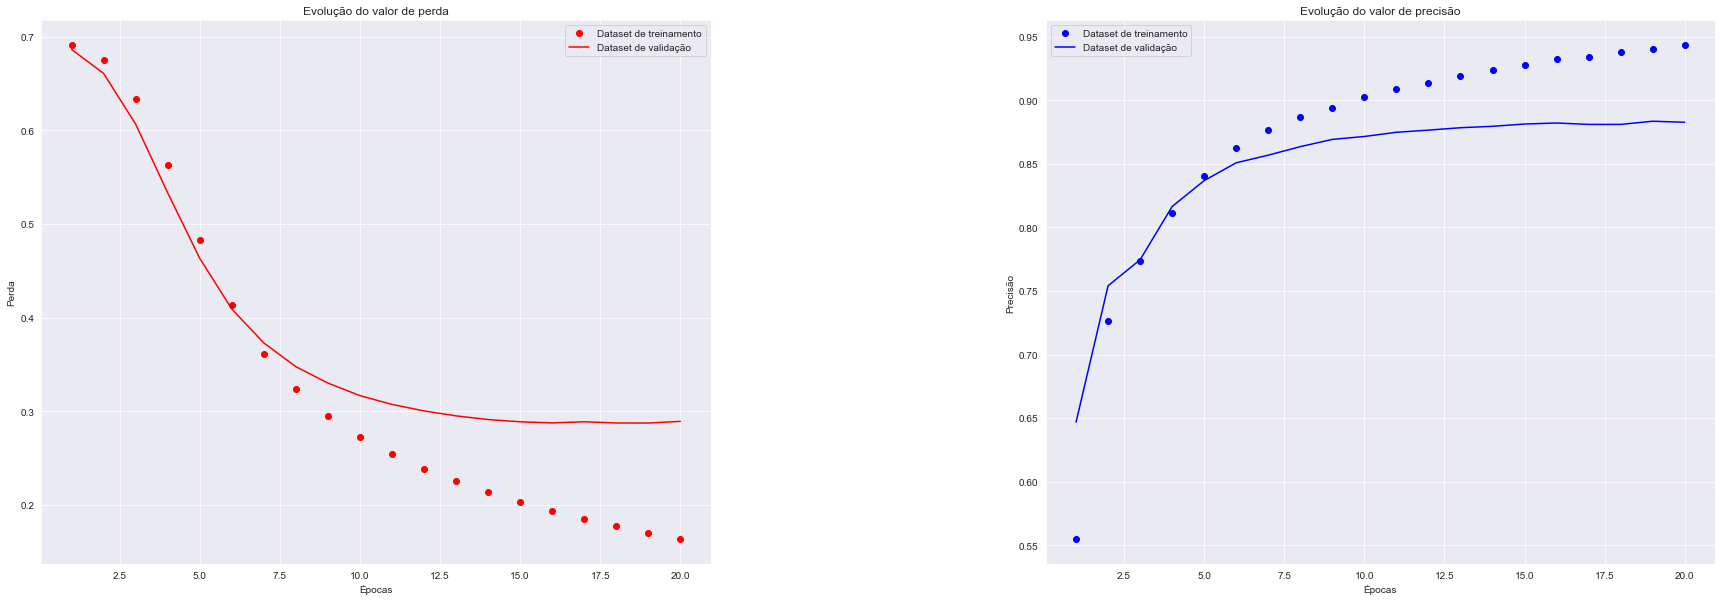

In [18]:
precisao = historico_dict['accuracy']
valor_precisao = historico_dict['val_accuracy']
perda = historico_dict['loss']
valor_perda = historico_dict['val_loss']

epocas = range(1, len(precisao) + 1)


plt.figure(figsize=(30,10))
# Montando o gráfico do valor de loss (perda)
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.title('Evolução do valor de perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.plot(epocas, perda, 'ro', label='Dataset de treinamento')
plt.plot(epocas, valor_perda, 'r', label='Dataset de validação')
plt.legend()
# plt.show()



# Montando o gráfico do valor de precisão
plt.subplot(1,2,2)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.title('Evolução do valor de precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.plot(epocas, precisao, 'bo', label='Dataset de treinamento')
plt.plot(epocas, valor_precisao, 'b', label='Dataset de validação')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.show()

Os dois gráficos acima nos permitem obter conclusões interessantes. A primeira é que conforme o número de épocas aumenta menor fica o valor de perda e consequentemente melhor fica nossa rede. Outra conclusão interessante é que conforme o número de épocas aumenta, a precião também aumenta até certo ponto onde se torna estável e praticamente não se altera, nos indicando que para obter uma precisão maior será necessário melhorar a nossa rede. Também é possível visualizar o *overfitting* ocorrendo, observe que no gráfico correspondente a precisão da rede os valores utilizando o dataset de treinamento são sempre superiores aos valores utilizando o dataset de validação, isso indica que nosso modelo esta se saindo melhor com dados que ele já viu e pior com dados novos que não participarão do treinamento.